Cambio a delimitado por ","

In [1]:

df = pd.read_csv('Calidad_de_agus_2023.csv', delimiter=';')

df.to_csv('Calidad_de_agus_2023.csv', index=False)

NameError: name 'pd' is not defined

LEO DATOS

In [1]:
import pandas as pd

# abrimos el archivo usando una función específica de pandas
raw_dataset = pd.read_csv("Calidad_de_agus_2023.csv")

raw_dataset

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,42,Balneario Municipal,BS094,23/8/2023,2023,invierno,12,13,9.41,8.67,...,2.3,66,75,<0.10,<0.005,<0.001,19.25,<0.15,36,Extremadamente deteriorada
165,42,Playa La Balandra,BS093,22/2/2023,2023,Verano,20,23,5.8,7.47,...,3.4,58,17,<0.10,<0.005,<0.001,<0.10,>5.00,no se pudo calcular,NaN
166,42,Playa La Balandra,BS093,10/5/2023,2023,otoño,18,13,5.93,8.35,...,2.10,<30,32.00,<0.10,<0.005,<1.0,54.87,<0.15,36,Extremadamente deteriorada
167,42,Playa La Balandra,BS093,14/11/2023,2023,primavera,20,14,8.22,8.30,...,<2.0,48,110,<0.10,0,<0.001,37.4,<0.15,35,Extremadamente deteriorada


Hago un head para ver de que tratan los datos

In [6]:
raw_dataset.head()

,"orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua"
0,"1,Canal Villanueva y Río Luján,TI001,22/2/2023..."
1,"1,Canal Villanueva y Río Luján,TI001,10/5/2023..."
2,"1,Canal Villanueva y Río Luján,TI001,23/8/2023..."
3,"1,Canal Villanueva y Río Luján,TI001,14/11/202..."
4,"2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023..."


Borro las colunas Orden, Codigo y ano ya que no aportan nada al analisis

In [2]:
raw_dataset = raw_dataset.drop('orden', axis=1)
raw_dataset = raw_dataset.drop('codigo', axis=1)
raw_dataset = raw_dataset.drop('año', axis=1)


Ahora en busca de nulos

In [4]:
raw_dataset.isna().sum()

sitios                      0
fecha                       0
campaña                     0
tem_agua                    0
tem_aire                    0
od                          0
ph                          1
olores                      0
color                       0
espumas                     0
mat_susp                    0
colif_fecales_ufc_100ml     0
escher_coli_ufc_100ml       0
enteroc_ufc_100ml           0
nitrato_mg_l                0
nh4_mg_l                    0
p_total_l_mg_l              1
fosf_ortofos_mg_l           0
dbo_mg_l                    1
dqo_mg_l                    0
turbiedad_ntu               0
hidr_deriv_petr_ug_l        0
cr_total_mg_l               0
cd_total_mg_l               0
clorofila_a_ug_l            0
microcistina_ug_l           0
ica                         1
calidad_de_agua            15
dtype: int64

Busco en cada una de las columnas cuales valores van a ser considerados nulos

In [1]:
#se revisa una por una las columnas
for idx, val in raw_dataset["calidad_de_agua"].value_counts().items():
  print(idx, val)

NameError: name 'raw_dataset' is not defined

Remplazo por nulos los valores que no nos interesan, no nos aportan informacion relevante
primero hago copia

In [3]:

preprocessed_dataset = raw_dataset.copy()
preprocessed_dataset['tem_agua'] = preprocessed_dataset['tem_agua'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['tem_aire'] = preprocessed_dataset['tem_aire'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['od'] = preprocessed_dataset['od'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['ph'] = preprocessed_dataset['ph'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['olores'] = preprocessed_dataset['olores'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['color'] = preprocessed_dataset['color'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)                                                                            
preprocessed_dataset['espumas'] = preprocessed_dataset['espumas'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['mat_susp'] = preprocessed_dataset['mat_susp'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['colif_fecales_ufc_100ml'] = preprocessed_dataset['colif_fecales_ufc_100ml'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['escher_coli_ufc_100ml'] = preprocessed_dataset['escher_coli_ufc_100ml'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['enteroc_ufc_100ml'] = preprocessed_dataset['enteroc_ufc_100ml'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['nitrato_mg_l'] = preprocessed_dataset['nitrato_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['nh4_mg_l'] = preprocessed_dataset['nh4_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['p_total_l_mg_l'] = preprocessed_dataset['p_total_l_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['fosf_ortofos_mg_l'] = preprocessed_dataset['fosf_ortofos_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['dbo_mg_l'] = preprocessed_dataset['dbo_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['dqo_mg_l'] = preprocessed_dataset['dqo_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['turbiedad_ntu'] = preprocessed_dataset['turbiedad_ntu'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['hidr_deriv_petr_ug_l'] = preprocessed_dataset['hidr_deriv_petr_ug_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['cr_total_mg_l'] = preprocessed_dataset['cr_total_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['cd_total_mg_l'] = preprocessed_dataset['cd_total_mg_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)
preprocessed_dataset['clorofila_a_ug_l'] = preprocessed_dataset['clorofila_a_ug_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra', 'falto un frasco'], pd.NA)
preprocessed_dataset['microcistina_ug_l'] = preprocessed_dataset['microcistina_ug_l'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra', 'Dato atípico'], pd.NA)
preprocessed_dataset['ica'] = preprocessed_dataset['ica'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra', 'no se pudo calcular'], pd.NA)
preprocessed_dataset['calidad_de_agua'] = preprocessed_dataset['calidad_de_agua'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible', 'sin muestra', 'envase sin muestra'], pd.NA)

#agrego las que faltan 
preprocessed_dataset['olores'] = preprocessed_dataset['olores'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['color'] = preprocessed_dataset['color'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['mat_susp'] = preprocessed_dataset['mat_susp'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['espumas'] = preprocessed_dataset['espumas'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['campaña'] = preprocessed_dataset['campaña'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)
preprocessed_dataset['calidad_de_agua'] = preprocessed_dataset['calidad_de_agua'].replace(['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó', 'inaccesible'], pd.NA)


Los valores ya fueron pasados a null. Ahora hay que hacer los cambios de tipos de variable y ver que hacer con los < y >

In [22]:
preprocessed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   sitios                   169 non-null    object
 1   fecha                    169 non-null    object
 2   campaña                  169 non-null    object
 3   tem_agua                 138 non-null    object
 4   tem_aire                 142 non-null    object
 5   od                       135 non-null    object
 6   ph                       133 non-null    object
 7   olores                   151 non-null    object
 8   color                    151 non-null    object
 9   espumas                  151 non-null    object
 10  mat_susp                 151 non-null    object
 11  colif_fecales_ufc_100ml  144 non-null    object
 12  escher_coli_ufc_100ml    144 non-null    object
 13  enteroc_ufc_100ml        144 non-null    object
 14  nitrato_mg_l             151 non-null    o

Para poder trabajar con con ciertas columnas hace falta hacer algunas transformaciones a las columnas campana, olor, color, espumas, mat_sup, calidad_de_agua.

Con respecto a la columna campana aplicamos la transformacion ordinal-encoding asumiendo un orden tal que 0->verano,1->otono,2->invierno,3->primavera (como es durante el anio)

Para las columnas olores, color, espumas,mat_susp reemplazamos con 0 la ausencia y con 1 la prescencia.

Por ultimo para la columna calidad_de_agua sera 0->muy deteriorada y 1->extremadamente deteriorada.



In [7]:



#analizamos los datos que tienen, ya que aveces algunos datos se anotan de distintas manera o
#difieren en una letra lo que hace que sea un dato completamente distinto
preprocessed_dataset['olores'].value_counts()
preprocessed_dataset['color'].value_counts()
preprocessed_dataset['campaña'].value_counts()
preprocessed_dataset['espumas'].value_counts()
preprocessed_dataset['mat_susp'].value_counts()
preprocessed_dataset['calidad_de_agua'].value_counts()




#Transformacion campaña

preprocessed_dataset['campaña']=preprocessed_dataset['campaña'].replace(['Verano','otoño','invierno','primavera'],['0','1','2','3'])
preprocessed_dataset['campaña'].astype(int)



#transformacion olores, color, espumas,mat_susp
preprocessed_dataset['olores']=preprocessed_dataset['campaña'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['color']=preprocessed_dataset['color'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['espumas']=preprocessed_dataset['espumas'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['mat_susp']=preprocessed_dataset['mat_susp'].replace(['Ausencia','Presencia'],['0','1'])

#transformacion calidad_de_agua
preprocessed_dataset['calidad_de_agua']=preprocessed_dataset['calidad_de_agua'].replace(['Muy deteriorada','Muy deteriorada ','Extremadamente deteriorada'],['0','0','1'])

#las tranformo a tipo float ya que generalmente para usar ciertas funciones requiere que sean de ese tipo

excluidos=['nitrato_mg_l','nh4_mg_l','p_total_l_mg_l','fosf_ortofos_mg_l','dbo_mg_l','dqo_mg_l ','hidr_deriv_petr_ug_l','cr_total_mg_l','cd_total_mg_l','clorofila_a_ug_l','microcistina_ug_l']
columnas=['tem_agua','tem_aire','od','ph','olores','color','espumas','mat_susp','colif_fecales_ufc_100ml'
           ,'escher_coli_ufc_100ml','enteroc_ufc_100ml','turbiedad_ntu','ica','calidad_de_agua']
preprocessed_dataset[columnas] = preprocessed_dataset[columnas].apply(pd.to_numeric, errors='coerce')

preprocessed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sitios                   169 non-null    object 
 1   fecha                    169 non-null    object 
 2   campaña                  169 non-null    object 
 3   tem_agua                 138 non-null    float64
 4   tem_aire                 142 non-null    float64
 5   od                       133 non-null    float64
 6   ph                       125 non-null    float64
 7   olores                   169 non-null    int64  
 8   color                    151 non-null    float64
 9   espumas                  151 non-null    float64
 10  mat_susp                 151 non-null    float64
 11  colif_fecales_ufc_100ml  144 non-null    float64
 12  escher_coli_ufc_100ml    144 non-null    float64
 13  enteroc_ufc_100ml        144 non-null    float64
 14  nitrato_mg_l             1

Ahora con los datos convertidos podemos usar funciones tales como boxplot para analizar
outliers.
Algunos valores son muy altos y otros muy bajos por lo que para mostrarlo y que se vea a detalle lo hacemos en varias partes.

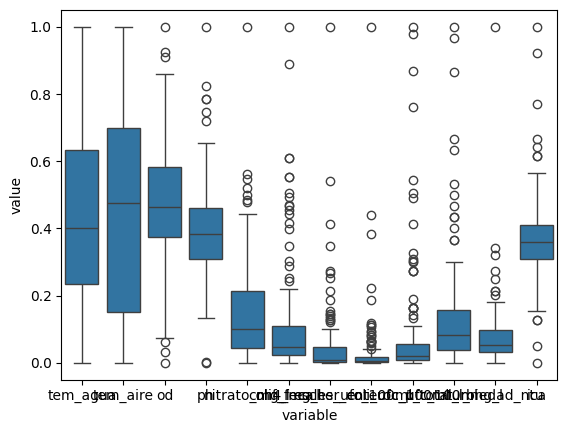

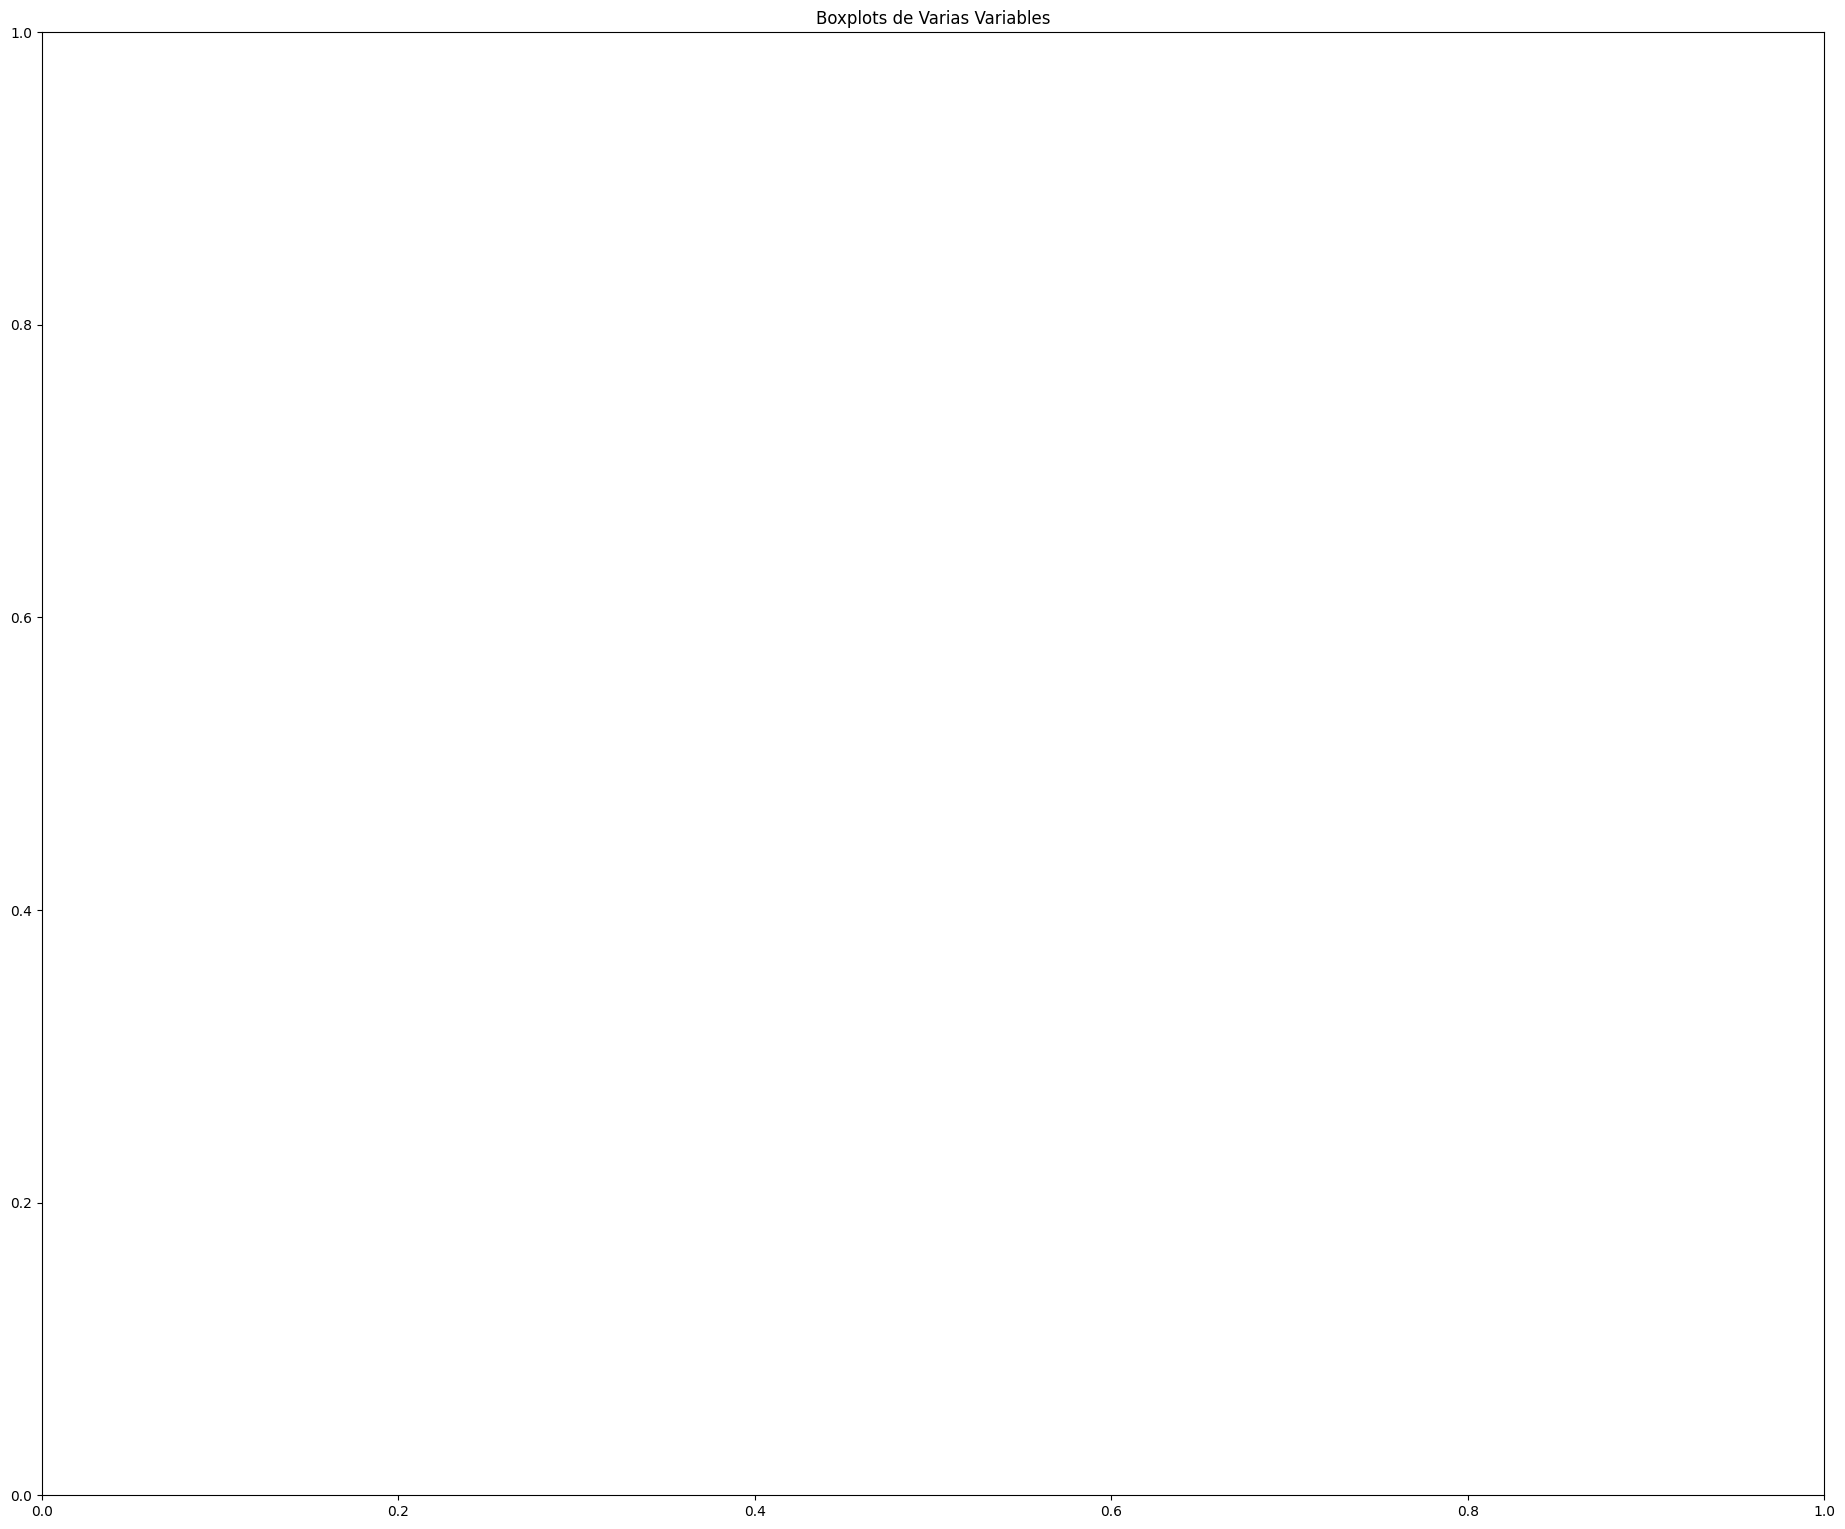

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Primero aplico un escalado para que sea tanta la diferencia entre valores



scaler= MinMaxScaler()
copia= preprocessed_dataset.copy()




#copia[columnas2] = copia[columnas2].fillna(copia[columnas2].mean())
copia[columnas2]= scaler.fit_transform(copia[columnas2])

#Faltas algunas pero por que todavia no realizamos la correccion como las de > <



datos = copia.melt(value_vars=columnas2)

# Crear los boxplots con Seaborn
sns.boxplot(x='variable', y='value', data=datos)
plt.figure(figsize=(23, 19))

plt.title("Boxplots de Varias Variables")
plt.show()

En base a lo que se observa en la grafica podriamos debatir si los outliers presentes 
pueden deberse a un error o no.

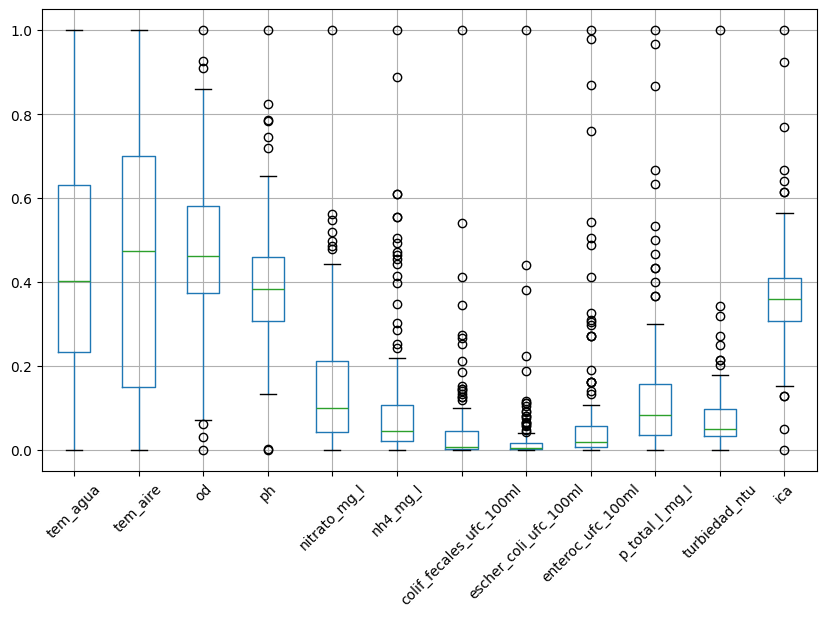

In [26]:
 # Selecciona las columnas que quieres visualizar
copia[columnas2].boxplot(figsize=(10, 6))
plt.xticks(rotation=45)
plt.show()